In [1]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn

In [2]:
def findFiles(path): return glob.glob(path)
print(findFiles("data/names/*.txt"))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles("data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

## Turning names into tensors

In [6]:
category_lines["Arabic"][:4]

['Khoury', 'Nahas', 'Daher', 'Gerges']

In [7]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def wordToTensor(word):
    tensor = torch.zeros(len(word), 1, n_letters)
    for li, letter in enumerate(word):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(wordToTensor("Jones").size())
        

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Creating the network

### character based model in which whole word is processed and then a category is the output
### Can be made more efficient as we are calculating the output multiple times when only it's needed in the last one

In [8]:
## Here input will be a word (character wise), and output will be a category
## It is a many-to-one model
class RNN(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [23]:
t1 = letterToTensor('A')
t2 = torch.zeros((3, 1, 57))
t2[1].shape

torch.Size([1, 57])

In [9]:
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(letterToTensor('A'), hidden)
output, next_hidden

(tensor([[-2.9712, -2.8566, -2.8639, -2.8313, -2.9420, -2.7973, -2.8026, -2.9913,
          -2.8250, -2.8851, -2.8110, -2.9604, -2.9679, -2.8766, -2.9736, -2.8580,
          -2.9122, -2.9373]], grad_fn=<LogSoftmaxBackward0>),
 tensor([[ 0.0191, -0.0343, -0.0749,  0.1240,  0.0285,  0.0137, -0.0161, -0.0374,
           0.0950, -0.0525,  0.0077, -0.0172,  0.0067,  0.0831, -0.0083,  0.0114,
           0.1291, -0.0793,  0.0287,  0.0353,  0.0226, -0.0851,  0.0519, -0.1058,
          -0.0193, -0.0328, -0.0493, -0.0140, -0.0043,  0.0518,  0.0727, -0.0845,
          -0.1161,  0.0369,  0.0642,  0.0672,  0.0024,  0.0351, -0.0016, -0.0106,
          -0.1183,  0.0679,  0.1290, -0.0080, -0.0332,  0.0493,  0.0912, -0.0828,
          -0.0070,  0.0907,  0.0388,  0.0320, -0.0018, -0.1062, -0.0764, -0.0518,
           0.0279,  0.0693,  0.1196,  0.0084, -0.0501,  0.0471,  0.0051, -0.0336,
           0.1210,  0.0020,  0.0446, -0.0370, -0.0749, -0.0646, -0.0025,  0.0818,
           0.0144, -0.0346, -0.0122,

## Training

In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # index of greatest value
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

categoryFromOutput(output)

('French', 5)

In [11]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = wordToTensor(line)
    return category, line, category_tensor, line_tensor

# for i in range(10):
#     category, line, category_tensor, line_tensor = randomTrainingExample()
    # print('category =', category, '/ line =', line)

category, line, category_tensor, line_tensor = randomTrainingExample()
category, line, category_tensor, line_tensor.size(), line_tensor[0]



('Dutch',
 'Kuiper',
 tensor([3]),
 torch.Size([6, 1, 57]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]]))

In [12]:
# Using NLLLoss cause we used LogSoftmax earlier.

# If you apply Pytorch’s CrossEntropyLoss to your output layer,
# you get the same result as applying Pytorch’s NLLLoss to a
# LogSoftmax layer added after your original output layer.

criterion = nn.NLLLoss()
lerning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lerning_rate)

    return output, loss.item()

In [13]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 2.5395 Batty / English ✓
10000 10% (0m 22s) 1.0896 Majewski / Polish ✓
15000 15% (0m 33s) 2.1578 Machado / Japanese ✗ (Portuguese)
20000 20% (0m 44s) 2.5466 Schlimme / Irish ✗ (German)
25000 25% (0m 55s) 1.9459 Duncan / Irish ✗ (Scottish)
30000 30% (1m 6s) 0.8080 Machado / Portuguese ✓
35000 35% (1m 16s) 1.0138 Ho / Vietnamese ✗ (Korean)
40000 40% (1m 26s) 1.3379 Jirku / Polish ✗ (Czech)
45000 45% (1m 37s) 0.7637 Esser / German ✓
50000 50% (1m 47s) 2.5547 Kocian / Polish ✗ (Czech)
55000 55% (1m 57s) 0.0323 Gwozdek / Polish ✓
60000 60% (2m 8s) 0.5461 Bilias / Greek ✓
65000 65% (2m 18s) 0.1043 Yanishevsky / Russian ✓
70000 70% (2m 28s) 4.0934 Haldoyanidi / Japanese ✗ (Russian)
75000 75% (2m 39s) 6.3447 Bauer / Arabic ✗ (Russian)
80000 80% (2m 50s) 0.4877 Chung / Korean ✓
85000 85% (3m 0s) 0.0091 Takimoto / Japanese ✓
90000 90% (3m 11s) 0.4695 Ryoo / Korean ✓
95000 95% (3m 22s) 2.7242 Oliver / Dutch ✗ (French)
100000 100% (3m 33s) 0.8489 Jumonji / Japanese ✓


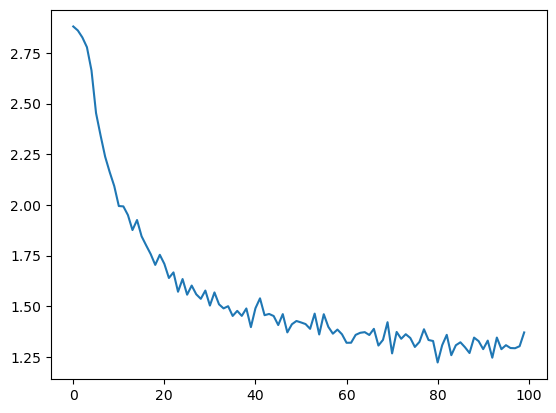

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)